In [108]:
import pandas as pd
!pip install catboost
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, r2_score
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
df = pd.read_csv('train_dataset_train.csv', nrows=1000)
#df

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1000 non-null   int64  
 1   ticket_id       1000 non-null   object 
 2   ticket_type_nm  1000 non-null   object 
 3   entrance_id     1000 non-null   int64  
 4   entrance_nm     1000 non-null   object 
 5   station_id      1000 non-null   int64  
 6   station_nm      1000 non-null   object 
 7   line_id         1000 non-null   int64  
 8   line_nm         1000 non-null   object 
 9   pass_dttm       1000 non-null   object 
 10  time_to_under   1000 non-null   float64
 11  label           1000 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 93.9+ KB


In [111]:
df[df.isna()==True].count()

id                0
ticket_id         0
ticket_type_nm    0
entrance_id       0
entrance_nm       0
station_id        0
station_nm        0
line_id           0
line_nm           0
pass_dttm         0
time_to_under     0
label             0
dtype: int64

In [112]:
cols = df.columns
for col in cols:
    print(f"Характеристика: {col}")
    print(f"Количество значений: {df[col].nunique()}")
   

Характеристика: id
Количество значений: 1000
Характеристика: ticket_id
Количество значений: 1000
Характеристика: ticket_type_nm
Количество значений: 28
Характеристика: entrance_id
Количество значений: 279
Характеристика: entrance_nm
Количество значений: 279
Характеристика: station_id
Количество значений: 205
Характеристика: station_nm
Количество значений: 186
Характеристика: line_id
Количество значений: 15
Характеристика: line_nm
Количество значений: 15
Характеристика: pass_dttm
Количество значений: 543
Характеристика: time_to_under
Количество значений: 986
Характеристика: label
Количество значений: 236


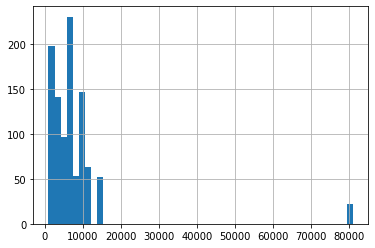

In [113]:
df["label"].hist(bins = 50)

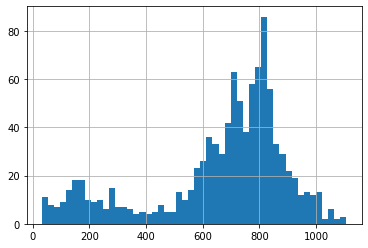

In [114]:
df["time_to_under"].hist(bins = 50)

In [115]:
#df.head()

In [116]:
#df["ticket_type_nm"].value_counts()

In [117]:
df["ticket_type_nm"] = pd.Categorical(df["ticket_type_nm"])
df["ticket_type_nm"].astype('category').cat.codes
df["ticket_type_nm"] = df["ticket_type_nm"].cat.codes

In [118]:
#df.head()

In [119]:
df.ticket_type_nm.nunique()

28

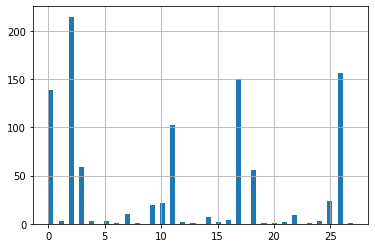

In [120]:
df.ticket_type_nm.hist(bins=60)

In [121]:
df["day"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[0]))
df["hours"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[0]))

In [122]:
#df.head()

In [123]:
features_to_use = ['ticket_type_nm', 'entrance_id', 'station_id', 'line_id', 'pass_dttm', 'time_to_under', 'label', 'hours', 'day']
df = df[features_to_use]
#df

In [124]:
categorical_features = ['ticket_type_nm', 'entrance_id', 'station_id', 'line_id', 'label']

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe.fit(df[categorical_features])
df_transformed = ohe.transform(df[categorical_features])
df[ohe.get_feature_names()] = df_transformed
categorical_features = categorical_features[:-1]
df = df.drop(categorical_features, axis=1)
#df.head(5)
#print(categorical_features)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = 

In [125]:
X = df[df.columns[2:len(df.columns)-276]]
X['day'] = df.day
X['hours'] = df.hours
X = X.drop('label', axis=1)

<ipython-input-125-ba6d5290b102>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['day'] = df.day
<ipython-input-125-ba6d5290b102>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['hours'] = df.hours


In [126]:
#X.info()

In [127]:
kmeans = KMeans(n_clusters=200, random_state=40).fit(X)
cluster = kmeans.predict(X)
X['cluster'] = cluster

In [128]:
X['cluster']

0       79
1        7
2        7
3      183
4       51
      ... 
995     92
996    101
997      5
998    102
999     68
Name: cluster, Length: 1000, dtype: int32

In [129]:
#df.columns

In [130]:
y_clf = df.label
y_reg = df.time_to_under

In [131]:
clf = CatBoostClassifier(iterations=100)
clf.fit(X, y_clf)

Learning rate set to 0.5
0:	learn: 5.2419064	total: 600ms	remaining: 59.4s
1:	learn: 5.0999584	total: 1.09s	remaining: 53.4s
2:	learn: 4.9939237	total: 1.61s	remaining: 52.2s
3:	learn: 4.9086593	total: 2.11s	remaining: 50.6s
4:	learn: 4.8653523	total: 2.6s	remaining: 49.4s
5:	learn: 4.7727822	total: 3.18s	remaining: 49.8s
6:	learn: 4.7087396	total: 3.74s	remaining: 49.7s
7:	learn: 4.6732269	total: 4.25s	remaining: 48.9s
8:	learn: 4.6223528	total: 4.87s	remaining: 49.2s
9:	learn: 4.5543171	total: 5.48s	remaining: 49.3s
10:	learn: 4.5232284	total: 6.01s	remaining: 48.7s
11:	learn: 4.4729327	total: 6.56s	remaining: 48.1s
12:	learn: 4.4147855	total: 7.07s	remaining: 47.3s
13:	learn: 4.3602773	total: 7.56s	remaining: 46.4s
14:	learn: 4.3424825	total: 8.06s	remaining: 45.7s
15:	learn: 4.3332102	total: 8.59s	remaining: 45.1s
16:	learn: 4.3203501	total: 9.08s	remaining: 44.3s
17:	learn: 4.3038935	total: 9.62s	remaining: 43.8s
18:	learn: 4.2894061	total: 10.2s	remaining: 43.3s
19:	learn: 4.2777

In [132]:
pred_class = clf.predict(X)
pred_class

array([[ 2010],
       [ 5009],
       [ 5009],
       [ 7003],
       [ 7020],
       [ 5007],
       [ 2010],
       [ 7014],
       [ 5007],
       [ 5009],
       [ 6010],
       [ 5009],
       [ 3020],
       [ 5007],
       [ 8006],
       [ 5007],
       [11020],
       [ 5009],
       [ 2010],
       [ 5007],
       [ 5007],
       [ 5009],
       [ 7014],
       [ 2023],
       [ 3020],
       [ 2010],
       [ 2010],
       [ 5009],
       [ 5009],
       [ 5009],
       [ 2010],
       [ 7014],
       [ 8007],
       [ 2010],
       [ 5009],
       [ 2010],
       [ 7020],
       [ 2010],
       [ 8006],
       [ 3011],
       [ 9009],
       [ 1005],
       [ 9009],
       [ 5009],
       [ 1005],
       [ 3001],
       [ 2012],
       [ 7020],
       [ 4004],
       [ 7003],
       [ 9009],
       [ 7020],
       [ 3002],
       [ 5007],
       [ 3002],
       [ 8008],
       [ 5009],
       [ 7003],
       [ 5009],
       [ 7020],
       [ 1005],
       [ 8008],
       [

In [133]:
reg = CatBoostRegressor(iterations=5000)
reg.fit(X, y_reg)

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 240.2094198	total: 2.39ms	remaining: 12s
1:	learn: 239.5803859	total: 4.79ms	remaining: 12s
2:	learn: 238.9355815	total: 6.92ms	remaining: 11.5s
3:	learn: 238.3724238	total: 9.28ms	remaining: 11.6s
4:	learn: 237.8114159	total: 11.5ms	remaining: 11.5s
5:	learn: 237.3010104	total: 13.6ms	remaining: 11.3s
6:	learn: 236.7736920	total: 15.9ms	remaining: 11.4s
7:	learn: 236.2681978	total: 18.1ms	remaining: 11.3s
8:	learn: 235.7409210	total: 20.5ms	remaining: 11.4s
9:	learn: 235.2067145	total: 22.8ms	remaining: 11.4s
10:	learn: 234.6824832	total: 25ms	remaining: 11.4s
11:	learn: 234.2058989	total: 27.4ms	remaining: 11.4s
12:	learn: 233.7135536	total: 30.3ms	remaining: 11.6s
13:	learn: 233.1885507	total: 32.4ms	remaining: 11.5s
14:	learn: 232.6761947	total: 34.6ms	remaining: 11.5s
15:	learn: 232.3499488	total: 36.9ms	remaining: 11.5s
16:	learn: 231.9017978	total: 39.3ms	remaining: 11.5s
17:	learn: 231.4005732	total: 

In [134]:
pred_class = clf.predict(X)
pred_reg = reg.predict(X)

In [135]:
score = 0.5 * recall_score(y_clf, pred_class , average='macro') +  0.5 * r2_score(y_reg, pred_reg)
score

0.39416923994070796